In [1]:
# import torch

# print("Number of GPU: ", torch.cuda.device_count())
# print("GPU Name: ", torch.cuda.get_device_name())


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

In [2]:
import os
import torch   #pytorch packege
import torch.nn as nn  #provides neural network building blocks
import torch.optim as optim #contains optimizers (SGD, Adam, RMSProp) that update weights during training.
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm

In [3]:
IMG_SIZE = 128       
BATCH_SIZE = 2
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
REAL_DIR  = "C:/Users/admin/Desktop/5th sem/Project-II/Dataset_resized/real/face"
CHIBI_DIR = "C:/Users/admin/Desktop/5th sem/Project-II/Dataset_resized/style/chibi/faces"
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs("./samples", exist_ok=True)


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),   # Resize the image to the specified size
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor and scale automatically to [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize the image to the range [-1, 1]
])

real_dataset  = datasets.ImageFolder(REAL_DIR,  transform=transform)
chibi_dataset = datasets.ImageFolder(CHIBI_DIR, transform=transform)

real_loader  = DataLoader(real_dataset,  batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
chibi_loader = DataLoader(chibi_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual=6):
        super().__init__()
        model = [
            nn.Conv2d(in_channels, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True)
        ]

        for _ in range(n_residual):
            model.append(ResidualBlock(256))

        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, out_channels, 7, padding=3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [9]:
G_AB = Generator().to(DEVICE)  # Real → Anime
G_BA = Generator().to(DEVICE)  # Anime → Real
D_A  = Discriminator().to(DEVICE)  # Real or fake?
D_B  = Discriminator().to(DEVICE)

In [10]:
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

opt_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=2e-4, betas=(0.5, 0.999))


In [11]:
start_epoch = 0
if os.path.exists(f"{CHECKPOINT_DIR}/G_AB.pth"):
    print("✅ Resuming from checkpoint...")
    G_AB.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/G_AB.pth"))
    G_BA.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/G_BA.pth"))
    D_A.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/D_A.pth"))
    D_B.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/D_B.pth"))
    opt_G.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/opt_G.pth"))
    opt_D.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/opt_D.pth"))
    start_epoch = torch.load(f"{CHECKPOINT_DIR}/epoch.pth")
    print(f"Resumed from epoch {start_epoch+1}")


✅ Resuming from checkpoint...
Resumed from epoch 16


In [ ]:
for epoch in range(start_epoch, EPOCHS):
    loop = tqdm(zip(real_loader, chibi_loader), total=min(len(real_loader), len(chibi_loader)))
    for i, ((real_imgs, _), (chibi_imgs, _)) in enumerate(loop):
        real_imgs, chibi_imgs = real_imgs.to(DEVICE), chibi_imgs.to(DEVICE)

        # ---------------- Generator ----------------
        fake_B = G_AB(real_imgs)
        fake_A = G_BA(chibi_imgs)

        rec_A = G_BA(fake_B)
        rec_B = G_AB(fake_A)

        loss_id_A = criterion_identity(G_BA(real_imgs), real_imgs) * 5.0
        loss_id_B = criterion_identity(G_AB(chibi_imgs), chibi_imgs) * 5.0

        loss_GAN_AB = criterion_gan(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_gan(D_A(fake_A), torch.ones_like(D_A(fake_A)))

        loss_cycle_A = criterion_cycle(rec_A, real_imgs) * 10.0
        loss_cycle_B = criterion_cycle(rec_B, chibi_imgs) * 10.0

        loss_G = loss_id_A + loss_id_B + loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # ---------------- Discriminator ----------------
        loss_D_A = (criterion_gan(D_A(real_imgs), torch.ones_like(D_A(real_imgs))) +
                    criterion_gan(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))) * 0.5
        loss_D_B = (criterion_gan(D_B(chibi_imgs), torch.ones_like(D_B(chibi_imgs))) +
                    criterion_gan(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))) * 0.5
        loss_D = loss_D_A + loss_D_B

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(G_loss=loss_G.item(), D_loss=loss_D.item())

    # Save sample
    save_image(fake_B[:4]*0.5+0.5, f"samples/fakeB_epoch{epoch+1}.png")
    save_image(fake_A[:4]*0.5+0.5, f"samples/fakeA_epoch{epoch+1}.png")

    # Save checkpoint
    torch.save(G_AB.state_dict(), f"{CHECKPOINT_DIR}/G_AB.pth")
    torch.save(G_BA.state_dict(), f"{CHECKPOINT_DIR}/G_BA.pth")
    torch.save(D_A.state_dict(), f"{CHECKPOINT_DIR}/D_A.pth")
    torch.save(D_B.state_dict(), f"{CHECKPOINT_DIR}/D_B.pth")
    torch.save(opt_G.state_dict(), f"{CHECKPOINT_DIR}/opt_G.pth")
    torch.save(opt_D.state_dict(), f"{CHECKPOINT_DIR}/opt_D.pth")
    torch.save(epoch, f"{CHECKPOINT_DIR}/epoch.pth")

Epoch [42/100]:  19%|█▉        | 193/1004 [01:00<04:09,  3.25it/s, D_loss=0.29, G_loss=2.89] 

In [ ]:
torch.save(G_AB.state_dict(), "generator_chibi_face.pth")

In [ ]:
# Recreate the model and load weights
G_AB = Generator().to(DEVICE)
G_AB.load_state_dict(torch.load("generator_chibi_face.pth", map_location=DEVICE))
G_AB.eval()


Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d

In [ ]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # scale to [-1, 1]
])

img = Image.open("C:/Users/admin/Desktop/5th sem/Project-II/Dataset_resized/real/face/faces/542.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(DEVICE)  # add batch dim


In [ ]:
with torch.no_grad():
    fake_ghibli = G_AB(input_tensor)

# De-normalize back to [0,1] for visualization
fake_ghibli = (fake_ghibli.squeeze(0).cpu() * 0.5 + 0.5).clamp(0,1)


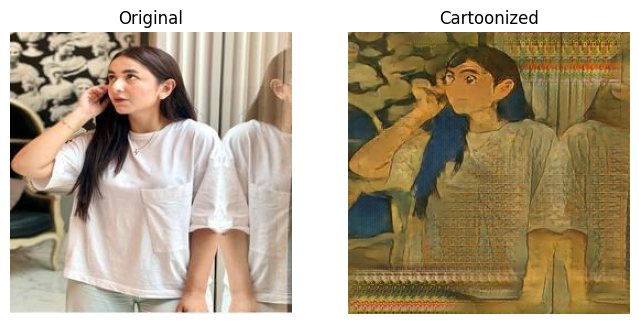

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

# Original
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

# Generated Cartoon
plt.subplot(1,2,2)
plt.imshow(fake_ghibli.permute(1,2,0).numpy())
plt.title("Cartoonized")
plt.axis("off")

plt.show()
